In [15]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models


# This code was tested with TensorFlow v1.8
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 2.5.0


## Данные

Данные были загружены по этой ссылке https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv 

In [16]:
data = pd.read_csv("bbc-text.csv")

In [17]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [18]:
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [19]:
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 1780
Test size: 445


In [20]:
def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

## Подготовка данных
Необходимо проделать некоторую работу, чтобы данные были готовы к обучению.
1. Разделим данные на обучающие и тестовые наборы..
1. Токенизируем слова, а затем преобразуем их в нумерованный индекс.
1. Делаем то же самое для меток (категорий), используя утилиту `LabelEncoder`.
1. мы конвертируем метки в одноразовое представление.

In [33]:
train_cat, test_cat = train_test_split(data['category'], train_size)
train_text, test_text = train_test_split(data['text'], train_size)

In [34]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

In [35]:
tokenize.fit_on_texts(train_text)
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [36]:
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

In [37]:
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [38]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1780, 1000)
x_test shape: (445, 1000)
y_train shape: (1780, 5)
y_test shape: (445, 5)


## Тренируем модель
Строим модель используя Keras 

In [39]:
batch_size = 32
epochs = 2
drop_ratio = 0.5

In [40]:
# Строим модель
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
# model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [41]:
# model.fit тренирует модель
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/2
51/51 [==============================] - 0s 4ms/step - loss: 0.4292 - accuracy: 0.8745 - val_loss: 0.1516 - val_accuracy: 0.9438
Epoch 2/2
51/51 [==============================] - 0s 3ms/step - loss: 0.0413 - accuracy: 0.9956 - val_loss: 0.1135 - val_accuracy: 0.9551


## Оценка модели

In [42]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

14/14 [==============================] - 0s 874us/step - loss: 0.1351 - accuracy: 0.9551
Test loss: 0.1351333111524582
Test accuracy: 0.9550561904907227


## Настройка гиперпараметров 

Необходимо настроить некоторые параметры, такие как «эпоха», «размер пакета», «коэффициент отсева», структура сети, функция активации и другие, чтобы посмотреть, можно ли повысить точность.

Рекомендуется уменьшить максимальное количество слов вызова до `keras.preprocessing.text.Tokenizer`. Это уменьшит количество слов для каждой входной выборки, что затруднит точное предсказание категории. (не все гиперпараметры обязательно находятся внутри модели. Это один из таких примеров.)

По умолчанию в статье было до 1000 слов. Посмотрим, что произойдет, если  уменьшите это число до 200 слов, или 50 слов, или даже меньше. По мере снижения точности оценки влияние настройки гиперпараметров будет более выраженным, а успешные корректировки существенно улучшат производительность модели.

Чтобы упростить управление этим процессом, я объединил вызовы определения модели, обучения и оценки в один вызов функции. При необходимости вы можете добавить дополнительные параметры. 

In [43]:
def run_experiment(batch_size, epochs, drop_ratio):
  print('batch size: {}, epochs: {}, drop_ratio: {}'.format(
      batch_size, epochs, drop_ratio))
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(max_words,)))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(drop_ratio))
  model.add(layers.Dense(num_classes))
  model.add(layers.Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1)
  score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=0)
  print('\tTest loss:', score[0])
  print('\tTest accuracy:', score[1])

In [44]:
batch_size = 16
epochs = 4
drop_ratio = 0.4
run_experiment(batch_size, epochs, drop_ratio)

batch size: 16, epochs: 4, drop_ratio: 0.4
	Test loss: 0.12104909867048264
	Test accuracy: 0.9595505595207214


## Предсказания
Взяты несколько образцов из тестового набора данных для проверки некоторых индивидуальных прогнозов, чтобы убедиться, что все разумно.

In [45]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_text.iloc[i][:50], "...")
    print('Actual label:' + test_cat.iloc[i])
    print("Predicted label: " + predicted_label + "\n")  

hobbit picture  four years away  lord of the rings ...
Actual label:entertainment
Predicted label: entertainment

game firm holds  cast  auditions video game firm b ...
Actual label:tech
Predicted label: tech

clarke plans migrant point scheme anyone planning  ...
Actual label:politics
Predicted label: politics

radcliffe will compete in london paula radcliffe w ...
Actual label:sport
Predicted label: sport

serena becomes world number two serena williams ha ...
Actual label:sport
Predicted label: sport

ultimate game  award for doom 3 sci-fi shooter doo ...
Actual label:tech
Predicted label: tech

algeria hit by further gas riots algeria suffered  ...
Actual label:business
Predicted label: business

fast lifts rise into record books two high-speed l ...
Actual label:tech
Predicted label: tech

muslim group attacks tv drama 24 a british muslim  ...
Actual label:entertainment
Predicted label: politics

us tv special for tsunami relief a us television n ...
Actual label:entertainment
Pre

## Дополнительно визуализируем результаты в виде матрицы

In [46]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [47]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

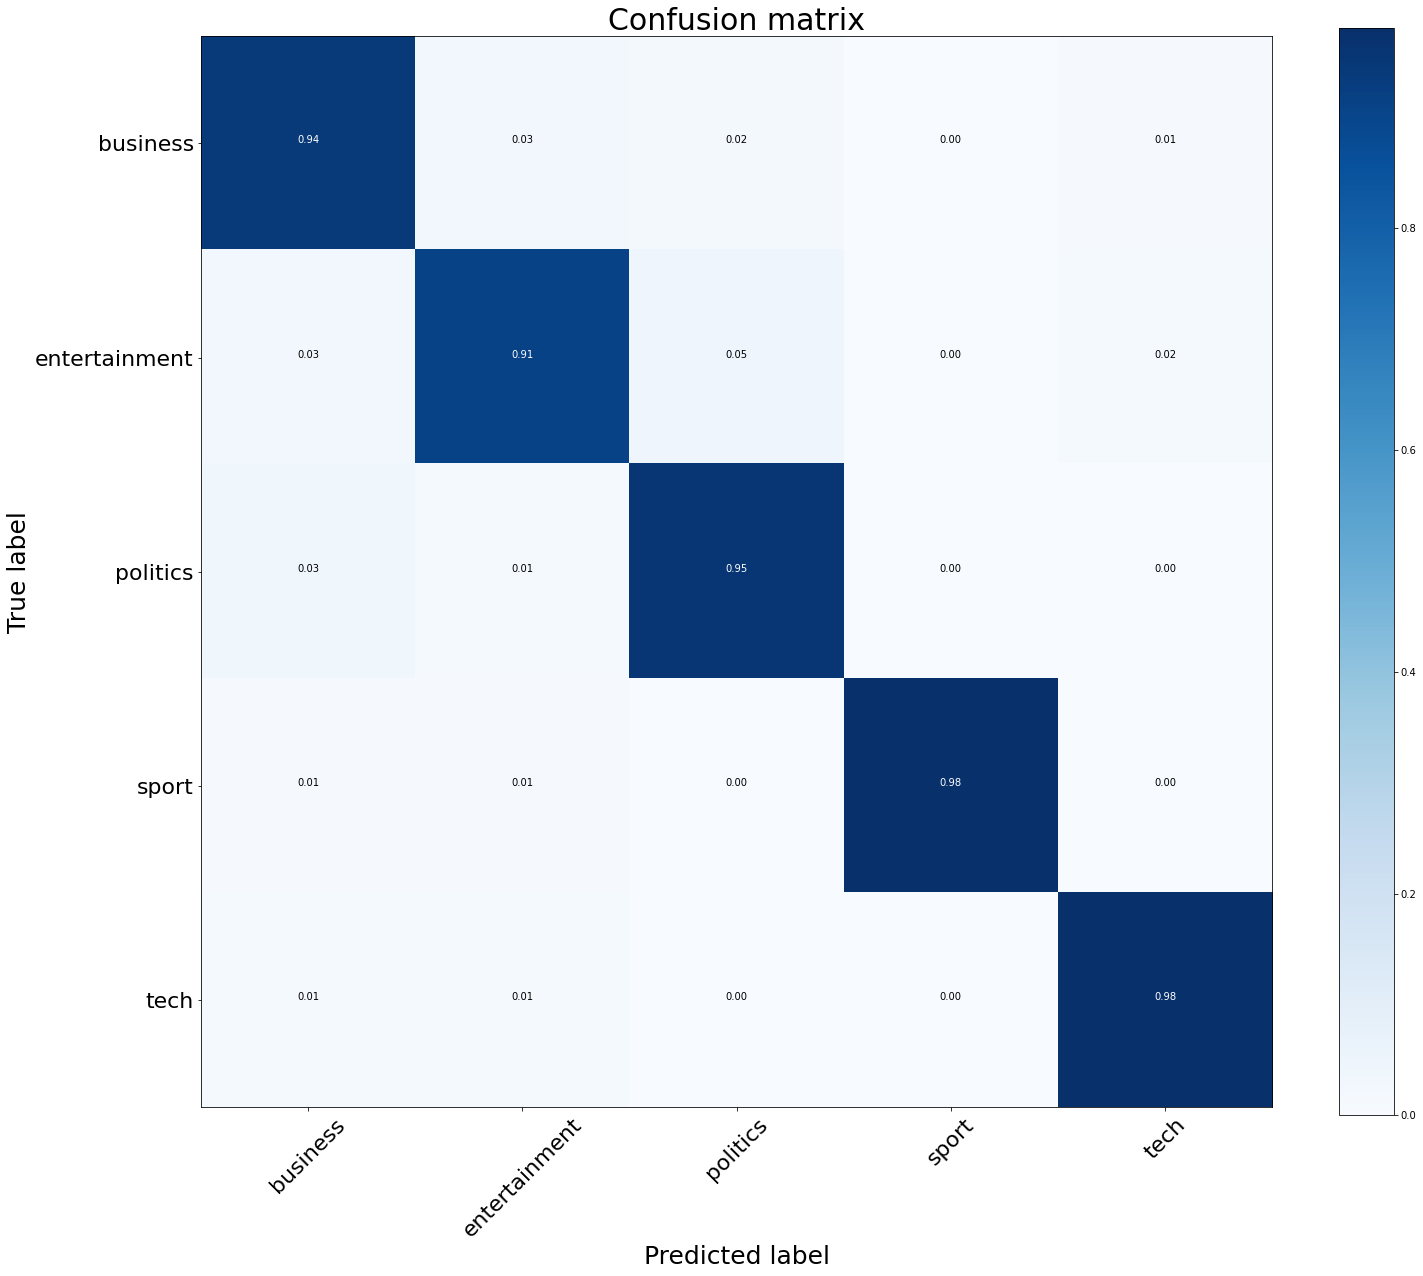

In [48]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()